In [ ]:
!pip install transformers

     |████████████████████████████████| 3.3 MB 7.3 MB/s 
     |████████████████████████████████| 3.3 MB 74.4 MB/s 
     |████████████████████████████████| 596 kB 73.0 MB/s 
     |████████████████████████████████| 61 kB 688 kB/s 
     |████████████████████████████████| 895 kB 89.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
FREEZE = False

In [ ]:
import nltk
import matplotlib.pyplot as plt
import pandas as pd
import collections
import numpy as np
import gc
gc.collect()
import re
from nltk.corpus import stopwords
import copy
import torch

from torch.utils.data import TensorDataset,random_split
from transformers import BertTokenizer
from torch.utils.data import DataLoader,RandomSampler,SequentialSampler
from transformers import BertForSequenceClassification, AdamW
from transformers import get_linear_schedule_with_warmup
import numpy as np
import random
import time
from sklearn.metrics import classification_report,accuracy_score,f1_score



In [ ]:
if torch.cuda.is_available():    
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

cuda


In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Dataset Preprocessing

###ENGLISH DATASET ANALYSIS

In [ ]:
ENGLISH_HOF = []
ENGLISH_NOT = []

In [ ]:
english_df_2019 = pd.read_csv('/content/gdrive/My Drive/NLP Project/data/2019/english_dataset/english_dataset_2019.csv', error_bad_lines=False)
english_df_2019 = english_df_2019.drop(columns=['task_2', 'task_3'])
print(english_df_2019.shape)
labels = collections.Counter(english_df_2019['task_1'])
ENGLISH_HOF.append(labels['HOF'])
ENGLISH_NOT.append(labels['NOT'])
print(labels)
print(english_df_2019.columns)
english_df_2019.head()

(5852, 3)
Counter({'NOT': 3591, 'HOF': 2261})
Index(['text_id', 'text', 'task_1'], dtype='object')


,text_id,text,task_1
0,hasoc_en_1,#DhoniKeepsTheGlove | WATCH: Sports Minister K...,NOT
1,hasoc_en_2,@politico No. We should remember very clearly ...,HOF
2,hasoc_en_3,@cricketworldcup Guess who would be the winner...,NOT
3,hasoc_en_4,Corbyn is too politically intellectual for #Bo...,NOT
4,hasoc_en_5,All the best to #TeamIndia for another swimmin...,NOT


In [ ]:
# english_df_2020 = pd.read_csv('/content/gdrive/My Drive/NLP Project/data/2020/english_dataset/english_dataset_2020.csv', error_bad_lines=False)
# english_df_2020 = english_df_2020.drop(columns=['task2'])
# print(english_df_2020.shape)
# print(english_df_2020.columns)
# labels = collections.Counter(english_df_2020['task1'])
# ENGLISH_HOF.append(labels['HOF'])
# ENGLISH_NOT.append(labels['NOT'])
# print(labels)
# english_df_2020.head()

In [ ]:
english_df_2019t = pd.read_csv('/content/gdrive/My Drive/NLP Project/data/2019/english_dataset/english_dataset_test_2019.csv', error_bad_lines=False)
print(english_df_2019t.columns)
english_df_2019t = english_df_2019t.drop(columns=['task_2', 'task_3'])
print(english_df_2019t.shape)
labels = collections.Counter(english_df_2019t['task_1'])
ENGLISH_HOF.append(labels['HOF'])
ENGLISH_NOT.append(labels['NOT'])
print(labels)
english_df_2019t.head()

Index(['text_id', 'text', 'task_1', 'task_2', 'task_3'], dtype='object')
(1153, 3)
Counter({'NOT': 865, 'HOF': 288})


,text_id,text,task_1
0,hasoc_en_902,West Bengal Doctor Crisis: Protesting doctors ...,NOT
1,hasoc_en_416,68.5 million people have been forced to leave ...,NOT
2,hasoc_en_207,"You came, you saw .... we will look after the ...",NOT
3,hasoc_en_595,We'll get Brexit delivered by October 31st. ...,NOT
4,hasoc_en_568,Fuck you. Go back to the dark ages you cow @IB...,HOF


In [ ]:
# english_df_2020t = pd.read_csv('/content/gdrive/My Drive/NLP Project/data/2020/english_dataset/english_dataset_test_2020.csv', error_bad_lines=False)
# english_df_2020t = english_df_2020t.drop(columns=['task2'])
# print(english_df_2020t.shape)
# print(english_df_2020t.columns)
# labels = collections.Counter(english_df_2020t['task1'])
# ENGLISH_HOF.append(labels['HOF'])
# ENGLISH_NOT.append(labels['NOT'])
# print(labels)
# english_df_2020t.head()

([<matplotlib.axis.XTick at 0x7f8acf42b150>,
 [Text(0, 0, 'train 2019'), Text(0, 0, 'test 2019')])

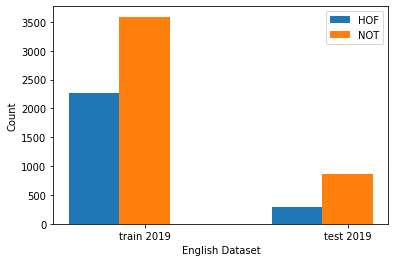

In [ ]:
barWidth = 0.25
br1 = np.arange(len(ENGLISH_HOF))
br2 = [x + barWidth for x in br1]
plt.bar(br1, ENGLISH_HOF, width=barWidth, label='HOF')
plt.bar(br2, ENGLISH_NOT, width=barWidth, label='NOT')
plt.legend()
plt.xlabel('English Dataset')
plt.ylabel('Count')
plt.xticks([r + barWidth for r in range(len(br1))],
        ['train 2019', 'test 2019'])

### CLEANING OF DATA - Remove STOP WORDS, tokens and twitter handles

In [ ]:
def modify_tweets(data):
  # print(data.columns)
  modified_tweets = []
  for text in data:

      #To remove @AnyName from the tweets
      text=re.sub(r"@[a-zA-z0-9]*\s+","",text) 
      text=re.sub(r"@[a-zA-z0-9]*:","",text)
      text=re.sub(r"@[a-zA-z0-9]*","",text)  
      text=re.sub(r"@[a-zA-z0-9]*$","",text)
      
      #To remove links
      text=re.sub(r"^https://t.co/[a-zA-Z0-9]*\s+"," ",text)    
      text=re.sub(r"\s+https://t.co/[a-zA-Z0-9]*\s+"," ",text)  
      text=re.sub(r"\s+https://t.co/[a-zA-Z0-9]*$"," ",text)    
      
      #To Convert all the tweets to low.
      # text=text.lower() 
      
      #To remove the shorthands
      text=re.sub(r"that's","that is ",text)
      text=re.sub(r"there's","there is ",text)
      text=re.sub(r"what's","what is ",text)
      text=re.sub(r"where's","where is ",text)
      text=re.sub(r"it's","it is ",text)
      text=re.sub(r"who's","who is ",text)
      text=re.sub(r"i'm","i am ",text)
      text=re.sub(r"she's","she is ",text)
      text=re.sub(r"he's","he is ",text)
      text=re.sub(r"they're","they are ",text)
      text=re.sub(r"who're","who are ",text)
      text=re.sub(r"ain't","am not ",text)
      text=re.sub(r"wouldn't","would not ",text)
      text=re.sub(r"shouldn't","should not ",text)
      text=re.sub(r"can't","cannot ",text)
      text=re.sub(r"couldn't","could not ",text)
      text=re.sub(r"won't","will not ",text)
      
      #To remove the single character
      text=re.sub(r"\s+[a-z]\s+"," ",text)
      text=re.sub(r"\s+[a-z]$"," ",text)
      text=re.sub(r"^[a-z]\s+"," ",text)
      
      #To remove non-word character
      text=re.sub(r"^[「人間はいわば感情に左右される生き物である」]*\s+"," ",text)
      text=re.sub(r"\s+[「人間はいわば感情に左右される生き物である」]*\s+"," ",text)
      text=re.sub(r"\s+[「人間はいわば感情に左右される生き物である」]*$"," ",text)
      text=re.sub(r"[!@$,%^&*\"><]*","",text)
      text=re.sub(r"\."," ",text)
      
      #To remove duplicate spaces
      text=re.sub(r"\s+"," ",text)
      
      #To remove digits 
      text=re.sub(r"\d"," ",text)
      
      #To remove non-word characters
      text=re.sub(r"\W"," ",text)
      
      modified_tweets.append(text)
  return modified_tweets

In [ ]:
print(english_df_2019.head(1)['text'])
english_df_2019['text'] = modify_tweets(english_df_2019['text'])
print(english_df_2019.head(1)['text'])

print(english_df_2019t.head(1)['text'])
english_df_2019t['text'] = modify_tweets(english_df_2019t['text'])
print(english_df_2019t.head(1)['text'])

# print(english_df_2020.head(1)['text'])
# english_df_2020['text'] = modify_tweets(english_df_2020['text'])
# print(english_df_2020.head(1)['text'])

# print(english_df_2020t.head(1)['text'])
# english_df_2020t['text'] = modify_tweets(english_df_2020t['text'])
# print(english_df_2020t.head(1)['text'])

0    #DhoniKeepsTheGlove | WATCH: Sports Minister K...
Name: text, dtype: object
0     DhoniKeepsTheGlove   WATCH  Sports Minister K...
Name: text, dtype: object
0    West Bengal Doctor Crisis: Protesting doctors ...
Name: text, dtype: object
0    West Bengal Doctor Crisis  Protesting doctors ...
Name: text, dtype: object


### Utility functions



1. encoder_generator(documents)
2. predictions_labels(preds,labels)
3. categorical_accuracy(preds, y)
4. predictions_labels(preds,labels)
5. train(model, train_data_loader)
6. evaluate(model, valid_data_loader)
7. evaluate_test(model, test_data_loader)
8. epoch_time(start_time, end_time)
9. plot_vc(acc_train, acc_val)
10. plot_loss(loss_train, loss_val)



In [ ]:
def encoder_generator(tokenizer, documents):
    
    doc_index = []
    input_ids = []
    attention_masks =[]

    for index,doc in enumerate(documents):
        
        doc_index.append(index)
        
        encoded_dict = tokenizer.encode_plus(doc,
                                             add_special_tokens=True,
                                             max_length=128,
                                             pad_to_max_length=True,
                                             truncation = True,
                                             return_attention_mask=True,
                                             return_tensors='pt')
        input_ids.append(encoded_dict['input_ids'])

        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids,dim=0)
    attention_masks = torch.cat(attention_masks,dim=0)
    sent_index = torch.tensor(doc_index)

    return sent_index,input_ids,attention_masks


In [ ]:
def predictions_labels(preds,labels):
    pred = np.argmax(preds,axis=1).flatten()
    label = labels.flatten()
    return pred,label

def categorical_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    max_preds = preds.argmax(dim = 1, keepdim = True) # get the index of the max probability
    correct = max_preds.squeeze(1).eq(y)
    return correct.sum() / torch.FloatTensor([y.shape[0]]).cuda()

def predictions_labels(preds,labels):
    pred = np.argmax(preds,axis=1).flatten()
    label = labels.flatten()
    return pred,label

In [ ]:
def train(model, train_data_loader, optimizer):
    total_train_loss = 0
    total_train_acc = 0
    
    model.train() # set model in train mode for batchnorm and dropout layers in bert model
    
    for step,batch in enumerate(train_data_loader):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        model.zero_grad()
            
        output = model(b_input_ids,
                            attention_mask=b_input_mask,
                            labels=b_labels.long())
        loss = output.loss
        logits = output.logits

        total_train_loss+=loss.item()
        total_train_acc+=categorical_accuracy(logits,b_labels).item()
            
        loss.backward()
            
        torch.nn.utils.clip_grad_norm_(model.parameters(),1.0)
            
        optimizer.step()
            
        scheduler.step() #go ahead and update the learning rate
            
    avg_train_loss = total_train_loss/len(train_data_loader)
    avg_train_acc = total_train_acc/len(train_data_loader)
    
    return avg_train_loss,avg_train_acc

In [ ]:
def evaluate(model, valid_data_loader):
    model.eval()
        
    total_eval_accuracy = 0
    total_eval_loss = 0
    number_of_eval_steps= 0
    
    all_true_labels = []
    all_pred_labels = []

    for batch in valid_data_loader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():

            output = model(b_input_ids,
                                attention_mask= b_input_mask,
                                labels = b_labels.long())
        loss = output.loss
        logits = output.logits

        total_eval_loss+=loss.item()

        logits = logits.detach().cpu().numpy()

        label_ids = b_labels.to('cpu').numpy()

        pred,true = predictions_labels(logits,label_ids)
        
        all_pred_labels.extend(pred)
        all_true_labels.extend(true)

    print(classification_report(all_pred_labels,all_true_labels))
    avg_val_accuracy = accuracy_score(all_pred_labels,all_true_labels)
    macro_f1_score = f1_score(all_pred_labels,all_true_labels,average='macro')
    
    avg_val_loss = total_eval_loss/len(valid_data_loader)

    print("accuracy = {0:.2f}".format(avg_val_accuracy))
    
    return avg_val_loss,avg_val_accuracy,macro_f1_score

In [ ]:
def evaluate_test(model, test_data_loader):
    model.eval()
        
    total_eval_accuracy = 0
    total_eval_loss = 0
    number_of_eval_steps= 0
    
    all_true_labels = []
    all_pred_labels = []
    
    all_sentence_id=[]

    for batch in test_data_loader:
        b_sentence_id = batch[0].to(device)
        b_input_ids = batch[1].to(device)
        b_input_mask = batch[2].to(device)
        b_labels = batch[3].to(device)

        sent_ids = b_sentence_id.to('cpu').numpy()
        all_sentence_id.extend(sent_ids)
        
        with torch.no_grad():

            output = model(b_input_ids,
                                attention_mask= b_input_mask,
                                labels = b_labels.long())
            
        loss = output.loss
        logits = output.logits
        
        total_eval_loss+=loss.item()

        logits = logits.detach().cpu().numpy()

        label_ids = b_labels.to('cpu').numpy()
        

        pred,true = predictions_labels(logits,label_ids)
        
        all_pred_labels.extend(pred)
        
        all_true_labels.extend(true)

    print(classification_report(all_pred_labels,all_true_labels))
    avg_val_accuracy = accuracy_score(all_pred_labels,all_true_labels)
    
    avg_val_loss = total_eval_loss/len(test_data_loader)

    print("accuracy = {0:.2f}".format(avg_val_accuracy))
    
    return avg_val_loss,avg_val_accuracy,all_sentence_id,all_pred_labels


In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


In [ ]:
def plot_vc(acc_train, acc_val):
  e = range(epochs)
  plt.plot(e, acc_train, 'g', label='Training Accuracy')
  plt.plot(e, acc_val, 'b', label='Validation Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

In [ ]:
def plot_lc(loss_train, loss_val):
  e = range(epochs)
  plt.plot(e, loss_train, 'g', label='Training Loss')
  plt.plot(e, loss_val, 'b', label='Validation Loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

## Train English

### BERT BASED MODEL - TRAINED FOR ENGLISH 

In [ ]:
train_data = english_df_2019.copy()
test_data = english_df_2019t.copy()
labels = {'HOF': 0, 'NOT': 1}

In [ ]:
train_data['task_1'] = train_data['task_1'].apply(lambda x: labels[x])
test_data['task_1'] = test_data['task_1'].apply(lambda x: labels[x])

In [ ]:
tokenizer_eng = BertTokenizer.from_pretrained('bert-base-uncased')

max_length = 0
for sentence in train_data['text']:
    #print(sentence)
    length = len(tokenizer_eng.tokenize(sentence))
    if length > max_length:
        max_length  = length
print("max token length in train_data is: ",max_length)

sent_index,input_ids,attention_masks = encoder_generator(tokenizer_eng, list(train_data['text']))
test_sent_index,test_input_ids,test_attention_masks = encoder_generator(tokenizer_eng, list(test_data['text']))
print('Original: ', train_data['text'][0])
print('Token IDs:', input_ids[0])

dataset = TensorDataset(input_ids,attention_masks,torch.tensor(train_data['task_1']))
test_dataset = TensorDataset(test_sent_index,test_input_ids,test_attention_masks,torch.tensor(test_data['task_1']))
train_size = int(0.8*len(dataset))
val_size = len(dataset)-train_size
train_dataset,val_dataset = random_split(dataset,[train_size,val_size])
print('train data samples is {}'.format(len(train_dataset)))
print("valid data samples is {}".format(len(val_dataset)))
print("test data samples is {}".format(len(test_dataset)))

bs=8

train_data_loader_eng = DataLoader(train_dataset,
                              sampler=RandomSampler(train_dataset),
                              batch_size=bs)
valid_data_loader_eng = DataLoader(val_dataset,
                              sampler=SequentialSampler(val_dataset),
                              batch_size=bs)
test_data_loader_eng = DataLoader(test_dataset,
                            sampler=SequentialSampler(test_dataset),
                            batch_size=bs)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

max token length in train_data is:  85


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2227: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:   DhoniKeepsTheGlove   WATCH  Sports Minister Kiren Rijiju issues statement backing MS Dhoni over  Balidaan Badge  tells BCCI to take up the matter with ICC and keep government in the know as nation s pride is involved 
Token IDs: tensor([  101, 28144, 10698, 20553,  4523, 10760, 23296, 21818,  3422,  2998,
         2704, 11382,  7389, 15544,  4478,  9103,  3314,  4861,  5150,  5796,
        28144, 10698,  2058, 20222,  2850,  2319, 10780,  4136,  4647,  6895,
         2000,  2202,  2039,  1996,  3043,  2007, 16461,  1998,  2562,  2231,
         1999,  1996,  2113,  2004,  3842,  1055,  6620,  2003,  2920,   102,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0, 

### Train BERT on ENGLISH

In [ ]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                                     num_labels=2,
                                                     output_attentions=False,
                                                     output_hidden_states=False,
                                                     )
model.cuda()

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
if FREEZE:
  del model
  import gc
  gc.collect()

  model = torch.load("/content/gdrive/MyDrive/NLP Project/model_pt/model_english_bert-base-uncased.pt")
  model = model.to(device)

else:

  optimizer = AdamW(model.parameters(),lr=2e-5,eps=1e-8)

  epochs=10
  total_steps = len(train_data_loader_eng) * epochs

  scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=total_steps)

  total_t0 = time.time()

  seed_val = 42

  random.seed(seed_val)
  np.random.seed(seed_val)
  torch.manual_seed(seed_val)
  torch.cuda.manual_seed_all(seed_val)

  epochs = 10

  best_macro_f1 = float('0')

  train_acc_eng = []
  val_acc_eng = []
  train_loss_eng = []
  val_loss_eng = []

  for epoch in range(epochs):
      
      start_time = time.time()
      train_loss,train_acc = train(model, train_data_loader_eng, optimizer)
      valid_loss,valid_acc,macro_f1 = evaluate(model, valid_data_loader_eng)
      
      end_time = time.time()
          
      epoch_mins, epoch_secs = epoch_time(start_time, end_time)
          
      if macro_f1 > best_macro_f1:
          best_macro_f1 = macro_f1
          torch.save(model,'/content/gdrive/MyDrive/NLP Project/model_pt/model_english_bert-base-uncased.pt')
      
      print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
      print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
      print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
      train_acc_eng.append(train_acc*100)
      val_acc_eng.append(valid_acc*100)
      train_loss_eng.append(train_loss*100)
      val_loss_eng.append(valid_loss*100)

              precision    recall  f1-score   support

           0       0.47      0.61      0.53       359
           1       0.80      0.70      0.75       812

    accuracy                           0.67      1171
   macro avg       0.64      0.65      0.64      1171
weighted avg       0.70      0.67      0.68      1171

accuracy = 0.67
Epoch: 01 | Epoch Time: 1m 18s
	Train Loss: 0.620 | Train Acc: 66.38%
	 Val. Loss: 0.608 |  Val. Acc: 66.95%
              precision    recall  f1-score   support

           0       0.56      0.61      0.58       424
           1       0.77      0.72      0.74       747

    accuracy                           0.68      1171
   macro avg       0.66      0.67      0.66      1171
weighted avg       0.69      0.68      0.69      1171

accuracy = 0.68
Epoch: 02 | Epoch Time: 1m 18s
	Train Loss: 0.514 | Train Acc: 75.68%
	 Val. Loss: 0.684 |  Val. Acc: 68.23%
              precision    recall  f1-score   support

           0       0.59      0.57      0.

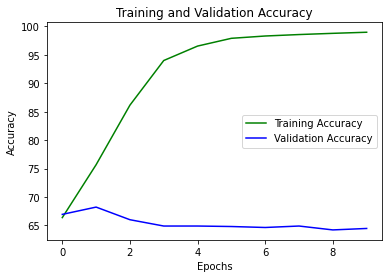

91.13267918088737
65.40563620836892


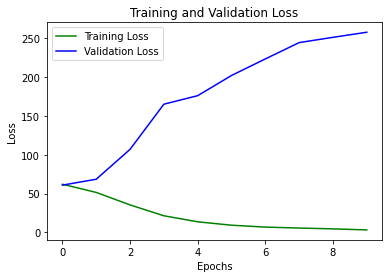

21.248263548375615
175.72111073684934


In [ ]:
plot_vc(train_acc_eng, val_acc_eng)
print(np.mean(train_acc_eng))
print(np.mean(val_acc_eng))

plot_lc(train_loss_eng, val_loss_eng)
print(np.mean(train_loss_eng))
print(np.mean(val_loss_eng))

### Evaluate English

In [ ]:
# if model:
#   del model
import gc
gc.collect()

model = torch.load("/content/gdrive/MyDrive/NLP Project/model_pt/model_english_bert-base-uncased.pt")
model = model.to(device)

valid_loss,valid_acc,all_sentence_id,all_pred_labels = evaluate_test(model, test_data_loader_eng)

              precision    recall  f1-score   support

           0       0.64      0.62      0.63       296
           1       0.87      0.88      0.88       857

    accuracy                           0.81      1153
   macro avg       0.76      0.75      0.75      1153
weighted avg       0.81      0.81      0.81      1153

accuracy = 0.81


## Hateful Meme Detection

### Hateful Meme Datatset - Captions

In [ ]:
import pandas as pd
hateful_meme_df = pd.read_json("/content/gdrive/MyDrive/NLP Project/data/hateful_meme/train.jsonl", lines=True)
hateful_meme_df = hateful_meme_df.drop(columns=['id', 'img'])
labels = collections.Counter(hateful_meme_df['label'])
print(labels)
hateful_meme_dft = pd.read_json("/content/gdrive/MyDrive/NLP Project/data/hateful_meme/test_unseen.jsonl", lines=True)
hateful_meme_dft = hateful_meme_dft.drop(columns=['id', 'img'])
labels = collections.Counter(hateful_meme_dft['label'])
hateful_meme_dft.head()

Counter({0: 5481, 1: 3019})


,label,text
0,1,when someone tells you how to bbq
1,1,when they say white folks don't know how to cook
2,1,the original derp-face
3,1,okay here you go! you piece of shit!
4,1,xboxone farming 1619 simulator


###Load Hateful Data

In [ ]:
train_data_fr = hateful_meme_df.copy()
test_data_fr = hateful_meme_dft.copy()
# labels = {'HOF': 1, 'NOT': 0}

# train_data['HS'] = train_data['HS'].apply(lambda x: labels[x])
# test_data['task_1'] = test_data['task_1'].apply(lambda x: labels[x])

tokenizer_fr = BertTokenizer.from_pretrained('bert-base-uncased')

max_length = 0
for sentence in train_data_fr['text']:
    #print(sentence)
    length = len(tokenizer_fr.tokenize(sentence))
    if length > max_length:
        max_length  = length
print("max token length in train_data is: ",max_length)

sent_index_fr,input_ids_fr,attention_masks_fr = encoder_generator(tokenizer_fr, list(train_data_fr['text']))
test_sent_index_fr,test_input_ids_fr,test_attention_masks_fr = encoder_generator(tokenizer_fr, list(test_data_fr['text']))
# print('Original: ', train_data_fr['text'][0])
# print('Token IDs:', input_ids_fr[0])
dataset_fr = TensorDataset(input_ids_fr,attention_masks_fr,torch.tensor(train_data_fr['label']))
test_dataset_fr = TensorDataset(test_sent_index_fr,test_input_ids_fr,test_attention_masks_fr,torch.tensor(test_data_fr['label']))

train_size_fr = int(0.8*len(dataset_fr))

val_size_fr = len(dataset_fr)-train_size_fr

train_dataset_fr,val_dataset_fr = random_split(dataset_fr,[train_size_fr,val_size_fr])

print('train data samples is {}'.format(len(train_dataset_fr)))
print("valid data samples is {}".format(len(val_dataset_fr)))
print("test data samples is {}".format(len(test_dataset_fr)))

bs=8

train_data_loader_fr = DataLoader(train_dataset_fr,
                              sampler=RandomSampler(train_dataset_fr),
                              batch_size=bs)
valid_data_loader_fr = DataLoader(val_dataset_fr,
                              sampler=SequentialSampler(val_dataset_fr),
                              batch_size=bs)
test_data_loader_fr = DataLoader(test_dataset_fr,
                            sampler=SequentialSampler(test_dataset_fr),
                            batch_size=bs)


max token length in train_data is:  86


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2227: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


train data samples is 6800
valid data samples is 1700
test data samples is 2000


In [ ]:
del model
import gc
gc.collect()

model = torch.load("/content/gdrive/MyDrive/NLP Project/model_pt/model_english_bert-base-uncased.pt")
model = model.to(device)

valid_loss_fr,valid_acc_fr,all_sentence_id_fr,all_pred_labels_fr = evaluate_test(model, test_data_loader_fr)

              precision    recall  f1-score   support

           0       0.13      0.57      0.21       288
           1       0.83      0.37      0.51      1712

    accuracy                           0.40      2000
   macro avg       0.48      0.47      0.36      2000
weighted avg       0.73      0.40      0.47      2000

accuracy = 0.40


### Train HM on pre trained BERT

In [ ]:
try:
  del model
except NameError:
  pass

model = BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                                     num_labels=2,
                                                     output_attentions=False,
                                                     output_hidden_states=False,
                                                     )
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:

import gc
gc.collect()

from transformers import AdamW



optimizer = AdamW(model.parameters(),lr=2e-5,eps=1e-8, weight_decay=0.1)

epochs=5
total_steps = len(train_data_loader_fr) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer,
                                           num_warmup_steps=0,
                                           num_training_steps=total_steps)

total_t0 = time.time()

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

best_macro_f1 = float('0')
train_acc_eng_fr = []
val_acc_eng_fr = []
train_loss_eng_fr = []
val_loss_eng_fr = []

for epoch in range(epochs):
    
    start_time = time.time()
    train_loss,train_acc = train(model, train_data_loader_fr, optimizer)
    valid_loss,valid_acc,macro_f1 = evaluate(model, valid_data_loader_fr)
    
    end_time = time.time()
        
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
    if macro_f1 > best_macro_f1:
        best_macro_f1 = macro_f1
        torch.save(model,"/content/gdrive/MyDrive/NLP Project/model_pt/model_hateful_meme.pt")
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    train_acc_eng_fr.append(train_acc*100)
    val_acc_eng_fr.append(valid_acc*100)
    train_loss_eng_fr.append(train_loss*100)
    val_loss_eng_fr.append(valid_loss*100)

              precision    recall  f1-score   support

           0       0.90      0.78      0.83      1290
           1       0.51      0.72      0.60       410

    accuracy                           0.76      1700
   macro avg       0.70      0.75      0.71      1700
weighted avg       0.80      0.76      0.78      1700

accuracy = 0.76
Epoch: 01 | Epoch Time: 1m 55s
	Train Loss: 0.555 | Train Acc: 73.29%
	 Val. Loss: 0.502 |  Val. Acc: 76.35%
              precision    recall  f1-score   support

           0       0.83      0.79      0.81      1169
           1       0.59      0.65      0.62       531

    accuracy                           0.75      1700
   macro avg       0.71      0.72      0.72      1700
weighted avg       0.76      0.75      0.75      1700

accuracy = 0.75
Epoch: 02 | Epoch Time: 1m 55s
	Train Loss: 0.449 | Train Acc: 80.34%
	 Val. Loss: 0.551 |  Val. Acc: 74.88%
              precision    recall  f1-score   support

           0       0.82      0.79      0.

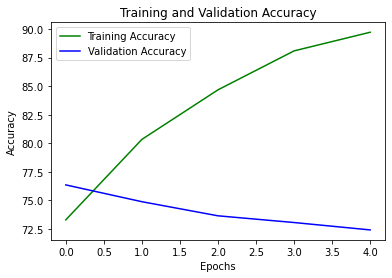

83.2235294117647
74.07058823529412


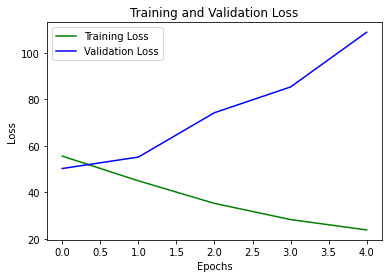

37.52766605127493
74.7034581800914


In [ ]:
plot_vc(train_acc_eng_fr, val_acc_eng_fr)
print(np.mean(train_acc_eng_fr))
print(np.mean(val_acc_eng_fr))

plot_lc(train_loss_eng_fr, val_loss_eng_fr)
print(np.mean(train_loss_eng_fr))
print(np.mean(val_loss_eng_fr))

###Evaluate Hateful Meme

In [ ]:
del model
import gc
gc.collect()

model = torch.load("/content/gdrive/MyDrive/NLP Project/model_pt/model_hateful_meme.pt")
model = model.to(device)

valid_loss_fr,valid_acc_fr,all_sentence_id_fr,all_pred_labels_fr = evaluate_test(model, test_data_loader_fr)

              precision    recall  f1-score   support

           0       0.86      0.65      0.74      1651
           1       0.24      0.51      0.32       349

    accuracy                           0.63      2000
   macro avg       0.55      0.58      0.53      2000
weighted avg       0.75      0.63      0.67      2000

accuracy = 0.63


### Train Hatespeech BERT on HM dataset




In [ ]:
try:
  del model_fr
except NameError:
  pass
import gc
gc.collect()

from transformers import AdamW


model_fr = torch.load('/content/gdrive/MyDrive/NLP Project/model_pt/model_english_bert-base-uncased.pt')
model_fr = model_fr.to(device)

optimizer_fr = AdamW(model_fr.parameters(),lr=2e-5,eps=1e-8, weight_decay=0.1)

epochs=5
total_steps = len(train_data_loader_fr) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer_fr,
                                           num_warmup_steps=0,
                                           num_training_steps=total_steps)

total_t0 = time.time()

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

best_macro_f1 = float('0')
train_acc_eng_fr = []
val_acc_eng_fr = []
train_loss_eng_fr = []
val_loss_eng_fr = []

for epoch in range(epochs):
    
    start_time = time.time()
    train_loss,train_acc = train(model_fr, train_data_loader_fr, optimizer_fr)
    valid_loss,valid_acc,macro_f1 = evaluate(model_fr, valid_data_loader_fr)
    
    end_time = time.time()
        
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
    if macro_f1 > best_macro_f1:
        best_macro_f1 = macro_f1
        torch.save(model_fr,"/content/gdrive/MyDrive/NLP Project/model_pt/model_hateful_meme_finetuned.pt")
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    train_acc_eng_fr.append(train_acc*100)
    val_acc_eng_fr.append(valid_acc*100)
    train_loss_eng_fr.append(train_loss*100)
    val_loss_eng_fr.append(valid_loss*100)

              precision    recall  f1-score   support

           0       0.89      0.78      0.83      1260
           1       0.53      0.71      0.61       440

    accuracy                           0.76      1700
   macro avg       0.71      0.75      0.72      1700
weighted avg       0.79      0.76      0.77      1700

accuracy = 0.76
Epoch: 01 | Epoch Time: 1m 55s
	Train Loss: 0.559 | Train Acc: 73.13%
	 Val. Loss: 0.511 |  Val. Acc: 76.47%
              precision    recall  f1-score   support

           0       0.83      0.80      0.81      1163
           1       0.59      0.64      0.62       537

    accuracy                           0.75      1700
   macro avg       0.71      0.72      0.71      1700
weighted avg       0.75      0.75      0.75      1700

accuracy = 0.75
Epoch: 02 | Epoch Time: 1m 55s
	Train Loss: 0.450 | Train Acc: 79.75%
	 Val. Loss: 0.535 |  Val. Acc: 74.76%
              precision    recall  f1-score   support

           0       0.79      0.81      0.

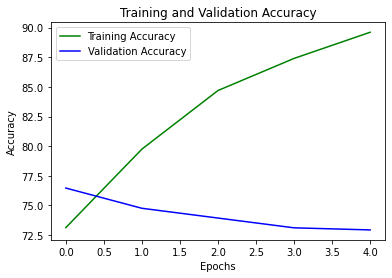

82.91470588235295
74.24705882352941


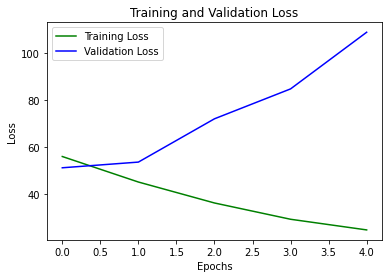

38.142760147844605
74.0750626605791


In [ ]:
plot_vc(train_acc_eng_fr, val_acc_eng_fr)
print(np.mean(train_acc_eng_fr))
print(np.mean(val_acc_eng_fr))

plot_lc(train_loss_eng_fr, val_loss_eng_fr)
print(np.mean(train_loss_eng_fr))
print(np.mean(val_loss_eng_fr))

###Evaluate BERT hatespeech-> hatememe

In [ ]:
del model_fr
import gc
gc.collect()

model_fr = torch.load("/content/gdrive/MyDrive/NLP Project/model_pt/model_hateful_meme_finetuned.pt")
model_fr = model_fr.to(device)

valid_loss_sp,valid_acc_sp,all_sentence_id_sp,all_pred_labels_sp = evaluate_test(model_fr, test_data_loader_fr)

              precision    recall  f1-score   support

           0       0.90      0.65      0.76      1715
           1       0.21      0.55      0.30       285

    accuracy                           0.64      2000
   macro avg       0.55      0.60      0.53      2000
weighted avg       0.80      0.64      0.69      2000

accuracy = 0.64
